In [35]:
%matplotlib inline
import os
import sys
import matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import cmath

from datetime import datetime, date

from sktensor import dtensor, cp_als
matplotlib.style.use('ggplot')

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import precision_recall_curve, average_precision_score
from sktensor import dtensor, cp_als

from numpy import linalg as LA

matplotlib.style.use('ggplot')

In [36]:
# Downloading and preprocessing the dataset
# The variable "tab" has integers datetime
execfile('Library/Initialization_rado_week_ML.py')
T.shape

73382 mails exchanged between 162 employees from 0.0 to 38.0
9.21814608574


(162, 162, 39)

## Dataset Temporal Split
We use (sender,receiver)_t matrix for t between t_0 and t_1. This temporal window shifts as t_0 incresases.  
t_0 is s.t. t_0+t_1 <= T.shape[2] = 39
  
Since we would like to move this window around 3 weeks, we choose t_0 <= 21 and a constant window size of length 238-21=217

In [57]:
t_0 = 0
t_1 = t_0 + 8

if t_1 <= T.shape[2]:
    T_train = T[:, :, t_0:t_1]
    T_test = T[:, :, t_1:]
    print('Initial time: t_0 = %d [%s]\nFinal time:   t_1 = %d [%s]') %(t_0,
                                                                                  k_list[t_0],
                                                                                  t_1,
                                                                                  k_list[t_1])
else:
    print('t_0=%d is superior to the maximal value 21!') %(t_0)

Initial time: t_0 = 0 [0.0]
Final time:   t_1 = 8 [8.0]


In [58]:
#Proportion of non-zero entries of the tensor
mail_rate = np.count_nonzero(T) / float(T.shape[0] * T.shape[1] * T.shape[2])

In [59]:
mail_rate

0.02933222343373235

# CanDecom/ParaFac (CP) Decomposition

In [92]:
# Defining a function for the outer product of several vectors
def Outer(vecs):
    # vecs can be either a list of vectors (n vectors of dimensions (**,1)) or an array of dimensions (**, n)
    vec_list = []
    if isinstance(vecs, list):
        vec_list = vecs
    elif isinstance(vecs, np.ndarray):
        vec_list = [vecs[:, j] for j in range(vecs.shape[1])]        

    res = reduce(np.multiply, np.ix_(*vec_list))
    return res

### Collapsed Unweighted Tensor  
Precision-Recall for several values of K

In [94]:
K_list = [1, 5, 10, 30, 50, 100]
tau_list = [1, 2, 4, 6]
S = np.zeros((T_train.shape[0], T_train.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

for tau_ind in range(len(tau_list)):
    # Choice of tau
    tau = tau_list[tau_ind]
    for K_ind in range(len(K_list)):
        # Choice of K
        K = K_list[K_ind]
        # CP Decomposition
        P, fit, itr, exectimes = cp_als(T_train, K, init='random')
        A, B, C = P.U
        # CP Scoring
        gamma = sum(C[-tau:, :], 0)  # The temporal coefficient
        Sk = sum(map(lambda x: gamma[x]*P.lmbda[x]*Outer([A[:, x], B[:, x]]), range(K)))
        for i in range(Sk.shape[0]) :
            for j in range(Sk.shape[1]) :
                Sk[i,j] = float(Sk[i,j])
        S += Sk/LA.norm(Sk, 'fro')

    y_score = S.flatten()
    y_test = S_test.flatten()
    
    # Precision-Recall
    #precision[tau], recall[tau], _ = precision_recall_curve(y_test, y_score)
    #average_precision[tau] = average_precision_score(y_test, y_score)    
    # ROC 
    FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
    AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)

    
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for tau_ind in range(len(tau_list)): 
    plt.plot(FPR[tau_ind], TPR[tau_ind], label='AUC={0:0.2f} - Tau=%d' .format(AUC[tau_ind]) %(tau_list[tau_ind]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week scale \nROC for CP Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('Radoslaw week cp_roc_cut.pdf')    

KeyboardInterrupt: 

### Exponential Smoothing  
Precision-Recall for several values of K

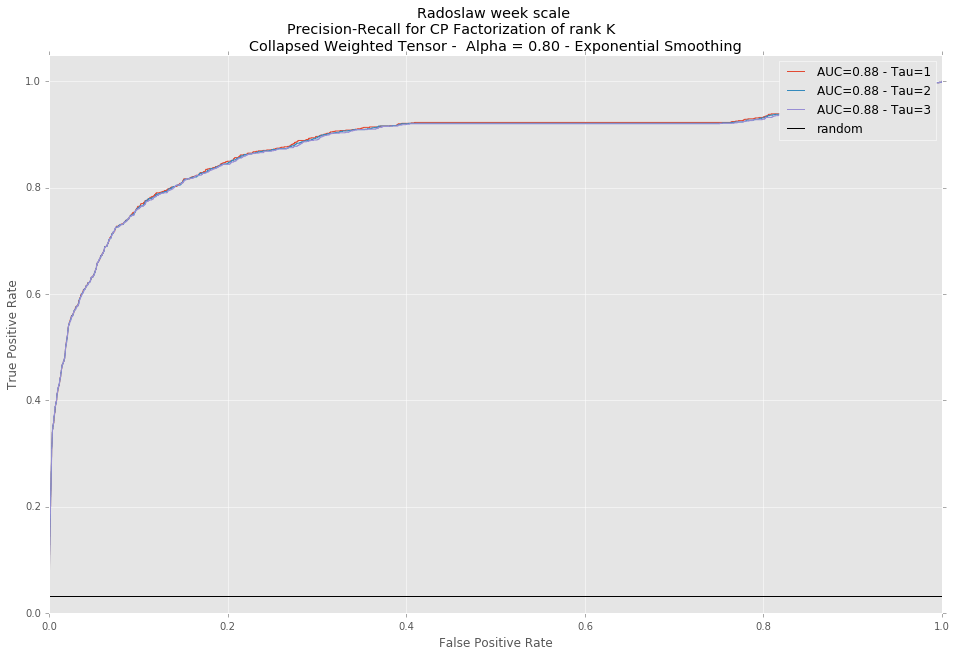

In [81]:
K_list = [1, 5, 10, 30, 50, 100]
tau_list = [1, 2, 4, 6]
alpha_list = [0.2, 0.5, 0.8]

for alpha_ind in range(len(alpha_list)):
    # Initialization
    FPR = dict()
    TPR = dict()
    AUC = dict()
    # Choice of alpha
    alpha = alpha_list[alpha_ind]
    for tau_ind in range(len(tau_list)):
        # Choice of tau
        tau = tau_list[tau_ind]
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # CP Decomposition
            P, fit, itr, exectimes = cp_als(T_train, K, init='random')
            A, B, C = P.U
            # CP Scoring
            gamma = sum(map(lambda x: ((1 - alpha) ** x) * alpha * C[-x, :], range(t_1 - t_0 - 1)), 0) + \
                    (1 - alpha) ** (t_1 - t_0 + 1) * C[0, :]                                 # Exponential smoothing
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk[i,j] = float(Sk[i,j])
            S += Sk/LA.norm(Sk, 'fro')

        y_score = S.flatten()
        y_test = (1*np.array(T_test[:, :, 0] >= 1)).flatten()

        # ROC 
        FPR[tau_ind], TPR[tau_ind], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[tau_ind] = sklearn.metrics.roc_auc_score(y_test, y_score)

    # Plotting the results
    plt.clf()
    plt.figure(figsize=(16, 10))

    for tau_ind in range(len(tau_list)): 
        plt.plot(FPR[tau_ind], TPR[tau_ind], label='AUC={0:0.2f} - Tau=%d' .format(AUC[tau_ind]) %(tau_list[tau_ind]))

    plt.axhline(mail_rate, label='random', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('Radoslaw week scale \nPrecision-Recall for CP Factorization of rank K \
                  \nCollapsed Weighted Tensor -  Alpha = %.2f - Exponential Smoothing' %(alpha))
    plt.savefig('Radoslaw week cp_roc_cwt_%.2f Exponential Smoothing.pdf' %(alpha))    

# TSVD, Katz, TKatz

## Collapsed unweighted tensor

In [60]:
CUT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))

for k in range(T.shape[2]):
    CUT = CUT + T[:,:,k]

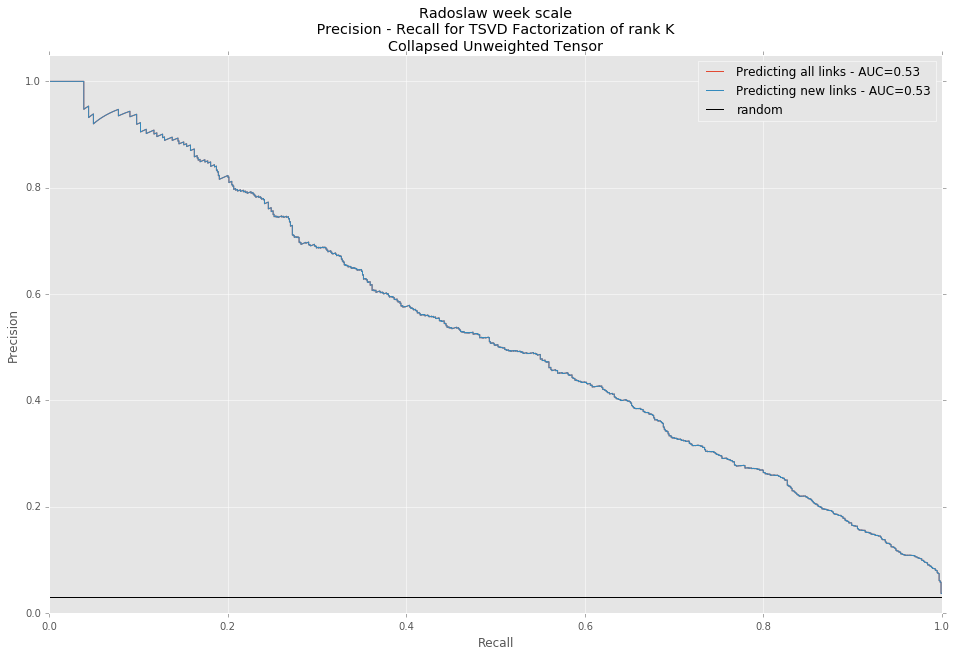

In [61]:
S = np.zeros((CUT.shape[0], CUT.shape[1]))
S_pred = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test_all = np.zeros((CUT.shape[0], CUT.shape[1]))
S_test = (1*np.array(T_test[:, :, 0] >= 1))

K_list = [1,5,10,30,50]
FPR = {}
TPR = {}
AUC = {}

precision = dict()
recall = dict()
average_precision = dict()

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
        
            y_test = S_test.flatten()

        # Precision-Recall
        precision[i], recall[i], _ = precision_recall_curve(y_test,y_score)
        average_precision[i] = average_precision_score(y_test, y_score)    

        # ROC 
        #FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        #AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        #plt.plot(FPR[i], TPR[i], label='Predicting all links - AUC={0:0.2f}' .format(AUC[i]))
        plt.plot(recall[i], precision[i], label='Predicting all links - AUC={0:0.2f}' .format(average_precision[i]))
    else :
        #plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))
        plt.plot(recall[i], precision[i], label='Predicting new links - AUC={0:0.2f}' .format(average_precision[i]))

plt.axhline(mail_rate, label='random', color='black')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
#plt.title('Radoslaw week scale\n ROC for TSVD Factorization of rank K \nCollapsed Unweighted Tensor')
#plt.savefig('Radoslaw week TSVD_roc_cut.pdf')   

plt.title('Radoslaw week scale\n Precision - Recall for TSVD Factorization of rank K \nCollapsed Unweighted Tensor')
plt.savefig('Radoslaw week TSVD_prec_rec_cut.pdf')   

### TKatz  
Precision-Recall for several values of Beta

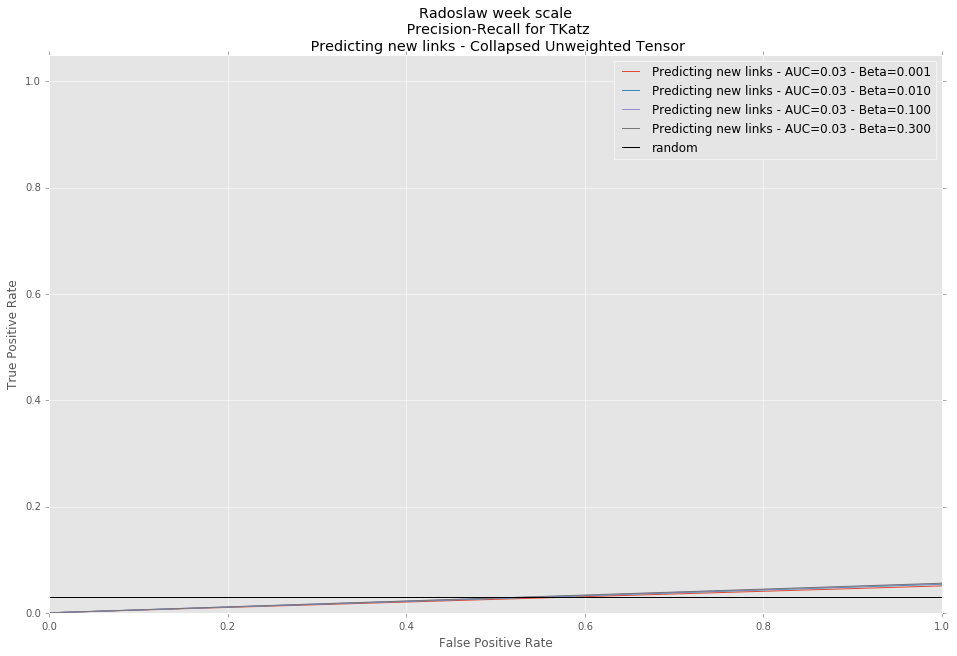

In [62]:
K_list = [1,5,10,30,50]
beta_list= [0.001, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CUT.shape[0], CUT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

precision = dict()
recall = dict()
average_precision = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CUT, n_components=K, n_iter=5, random_state=None)
            D, W = np.linalg.eig(np.dot(U,np.dot(np.diag(Sigma), Vt)))
            gamma = []
            for j in range(len(D)) :
                gamma += [1/(1-beta*D[j]) - 1]
            Sk = np.dot(W,np.dot(np.diag(gamma), W.transpose()))
            Sk_real = np.zeros((Sk.shape[0], Sk.shape[1]))
            for i in range(Sk.shape[0]) :
                for j in range(Sk.shape[1]) :
                    Sk_real[i,j] = Sk[i,j].real
            S += Sk_real/LA.norm(Sk_real, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CUT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

                
        # Precision-Recall
        precision[count], recall[count], _ = precision_recall_curve(y_test,y_score)
        average_precision[count] = average_precision_score(y_test, y_score) 
        #ROC
        #FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        #AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
        count += 1

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    #plt.plot(FPR[count], TPR[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
    #                                                       .format(AUC[count]) %(beta_list[B_ind]))
    plt.plot(recall[count], precision[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f'\
                                                            .format(average_precision[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
#plt.title('Radoslaw week scale\n ROC for TKatz\n Predicting all links - Collapsed Unweighted Tensor')
#plt.savefig('Radoslaw week Predicting all links TKatz_roc_cut.pdf')  
plt.title('Radoslaw week scale\n Precision-Rcall for TKatz\n Predicting all links - Collapsed Unweighted Tensor')
plt.savefig('Radoslaw week Predicting all links TKatz_prec_cut.pdf')  

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
for B_ind in range(len(beta_list)):
    #plt.plot(FPR[count], TPR[count], label= 'Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
    #                                                       .format(AUC[count]) %(beta_list[B_ind]))
    plt.plot(recall[count], precision[count], label='Predicting new links - AUC={0:0.2f} - Beta=%0.3f'\
                                                            .format(average_precision[count]) %(beta_list[B_ind]))
    count += 1

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
#plt.title('Radoslaw week scale\n ROC for TKatz\n Predicting new links - Collapsed Unweighted Tensor')
#plt.savefig('Radoslaw week Predicting new links TKatz_roc_cut.pdf')  
plt.title('Radoslaw week scale\n Precision-Recall for TKatz\n Predicting new links - Collapsed Unweighted Tensor')
plt.savefig('Radoslaw week Predicting new links TKatz_prec_cut.pdf')  

## Collapsed weighted tensor

In [63]:
CWT = np.zeros((T[:,:,0].shape[0], T[:,:,0].shape[1]))
theta = 0.2
K = len(k_list)

for k in range(K):
    CwT = CWT + (1-theta)**(K - k)*T[:,:,k]

In [64]:
CWT

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### TSVD  
Precision-Recall for several values of K

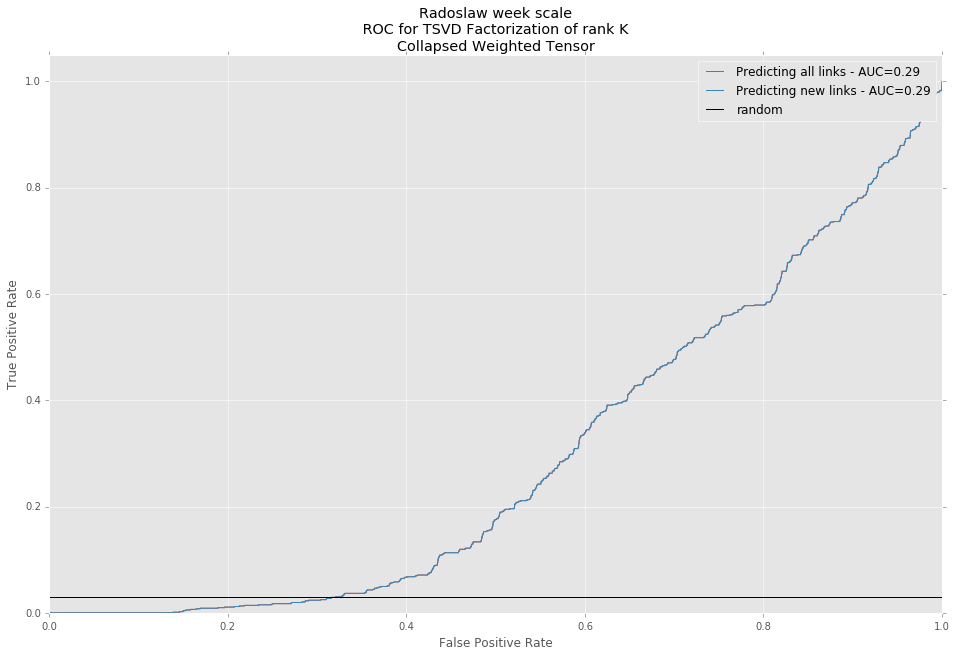

In [65]:
S = np.zeros((CWT.shape[0], CWT.shape[1]))

theta = 0.2
K_list = [1,5,10,30,50]
FPR = dict()
TPR = dict()
AUC = dict()

S_test = (1*np.array(T_test[:, :, 0] >= 1))

for i in range(2) :
        for K_ind in range(len(K_list)):
            # Choice of K
            K = K_list[K_ind]
            # TSVD Decomposition
            U, Sigma, Vt = randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            # TSVD Scoring
            Sk = np.dot(np.dot(U,np.diag(Sigma)),Vt)
            S+= Sk/LA.norm(Sk, 'fro')
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        # ROC 
        FPR[i], TPR[i], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[i] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

for i in range(2) :
    if i == 0:
        plt.plot(FPR[i], TPR[i], label='Predicting all links - AUC={0:0.2f}' .format(AUC[i]))
    #plt.plot(recall, precision, label='AUC={0:0.2f}' .format(average_precision))
    else :
        plt.plot(FPR[i], TPR[i], label='Predicting new links - AUC={0:0.2f}' .format(AUC[i]))

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week scale\n ROC for TSVD Factorization of rank K \nCollapsed Weighted Tensor')
plt.savefig('Radoslaw week TSVD_roc_cwt.pdf')      

### TKatz  
Precision-Recall for several values of Beta

Test n°0
Test n°1
Test n°2
Test n°3
Test n°4
Test n°5
Test n°6
Test n°7


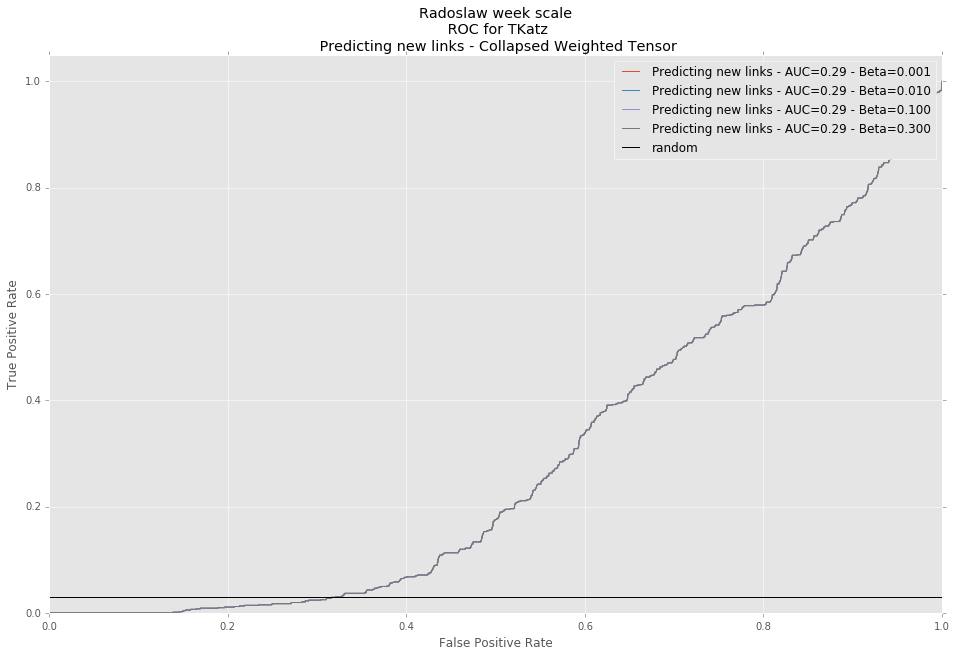

In [66]:
K_list = [1,5,10,30,50]
beta_list= [0.001, 0.01, 0.1, 0.3]
S_test = (1*np.array(T_test[:, :, 0] >= 1))
S = np.zeros((CWT.shape[0], CWT.shape[1]))

# Initialization
FPR = dict()
TPR = dict()
AUC = dict()

count = 0

for i in range(2) :
    for B_ind in range(len(beta_list)) :
        # Choice of beta
        beta = beta_list[B_ind]
        for K_ind in range(len(K_list)) :
            K=K_list[K_ind]
            U, Sigma, Vt= randomized_svd(CWT, n_components=K, n_iter=5, random_state=None)
            D, W = np.linalg.eig(np.dot(U,np.dot(np.diag(Sigma), Vt)))
            gamma = []
            for j in range(len(D)) :
                gamma += [1/(1-beta*D[j]) - 1]
            Sk = np.dot(W,np.dot(np.diag(gamma), W.transpose()))
            S += Sk/LA.norm(Sk, 'fro')
        print('Test n°%d' %(count))        
        if i == 0 :
            y_score = S.flatten()
            y_test = S_test.flatten()  
        else :
            nonz = CWT.nonzero()
            for ind in range(len(nonz[0])):
                i_ind = nonz[0][ind]
                j_ind = nonz[1][ind] 
                S[i_ind, j_ind] = 0
            y_score = S.flatten()
            y_test = S_test.flatten()

        #ROC
        FPR[count], TPR[count], _ = sklearn.metrics.roc_curve(y_test, y_score)
        AUC[count] = sklearn.metrics.roc_auc_score(y_test, y_score)
        
        count += 1


# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))

count = 0
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label='Predicting all links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
    count += 1
            
plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week scale\n ROC for TKatz\n Predicting all links - Collapsed Weighted Tensor')
plt.savefig('Radoslaw week Predicting all links TKatz_roc_cwt_%d.pdf' %(beta))  

# Plotting the results
plt.clf()
plt.figure(figsize=(16, 10))
for B_ind in range(len(beta_list)):
    plt.plot(FPR[count], TPR[count], label= 'Predicting new links - AUC={0:0.2f} - Beta=%0.3f' \
                                                           .format(AUC[count]) %(beta_list[B_ind]))
count += 1

plt.axhline(mail_rate, label='random', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Radoslaw week scale\n ROC for TKatz\n Predicting new links - Collapsed Weighted Tensor')
plt.savefig('Radoslaw week Predicting new links TKatz_roc_cwt_%d.pdf' %(beta))  